<a href="https://colab.research.google.com/github/quanndm/kltn/blob/dev/notebooks/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Init - import library - download data

In [1]:
!rm -rf kltn
!rm -rf sample_data
!git clone -b dev https://github.com/quanndm/kltn.git

Cloning into 'kltn'...
remote: Enumerating objects: 739, done.
remote: Counting objects: 100% (47/47), done.
remote: Compressing objects: 100% (39/39), done.
remote: Total 739 (delta 22), reused 23 (delta 8), pack-reused 692 (from 1)
Receiving objects: 100% (739/739), 5.16 MiB | 4.05 MiB/s, done.
Resolving deltas: 100% (477/477), done.


In [2]:
from kltn.init.install_dependencies import install_packages, load_config
install_packages("./kltn")
config = load_config("./kltn/parameters.yaml")


In [3]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from google.colab import drive

from kltn import *
from kltn.datasets.get_datasets import get_datasets_lits
from kltn.utils.logger import init_logger
from kltn.utils.train_val_epochs import trainer, val_epoch
from kltn.utils.metrics import DiceLossWSigmoid, DiceLossWSoftmax, DiceMetric
from kltn.models.model_factory import ModelFactory
from kltn.utils.visualize_results import visualize_results

In [4]:
drive.flush_and_unmount()
drive.mount("/content/drive")

Mounted at /content/drive


In [5]:
LOGGER = init_logger(config["log_path"])
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [7]:
from kltn.datasets.prepare_data import prepare_dataset_LiTS
prepare_dataset_LiTS(dir_name=config["source_folder_lits"])

0.37% complete (down: 0.0 kB/s up: 0.0 kB/s peers: 1) downloading LITS17 (https://academictorrents.com/announce.php)[127.0.0.1:6881] v1 skipping tracker announce (unreachable) "" (1)
LITS17 (https://academictorrents.com/announce.php)[172.28.0.12:6881] v1 unspecified system error "" (1)
LITS17 (https://ipv6.academictorrents.com/announce.php)[127.0.0.1:6881] v1 skipping tracker announce (unreachable) "" (1)
LITS17 (https://ipv6.academictorrents.com/announce.php)[172.28.0.12:6881] v1 unspecified system error "" (1)
LITS17 (udp://tracker.opentrackr.org:1337/announce)[127.0.0.1:6881] v1 skipping tracker announce (unreachable) "" (1)
2.29% complete (down: 17770.6 kB/s up: 501.2 kB/s peers: 9) downloading LITS17 (https://academictorrents.com/announce.php)[127.0.0.1:6881] v1 skipping tracker announce (unreachable) "" (2)
LITS17 (https://ipv6.academictorrents.com/announce.php)[127.0.0.1:6881] v1 skipping tracker announce (unreachable) "" (2)
LITS17 (https://ipv6.academictorrents.com/announce.ph

## Load data

In [6]:
full_train_dataset, val_dataset = get_datasets_lits(source_folder=config["source_folder_lits"], seed=123, fold_number=2)
print(len(full_train_dataset), len(val_dataset))

105 26


In [7]:
train_loader = torch.utils.data.DataLoader(full_train_dataset, batch_size=1, shuffle=True,
                                           num_workers=1, pin_memory=True, drop_last=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=1, shuffle=False,
                                         pin_memory=True, num_workers=1)

print("Train dataset number of batch:", len(train_loader))
print("Val dataset number of batch:", len(val_loader))

Train dataset number of batch: 105
Val dataset number of batch: 26


In [8]:
for batch in train_loader:
    # Assuming your input data is a 5D tensor (batch_size, channels, deep, height, width)
    data_shape = batch['image'].shape
    label_shape = batch['label'].shape
    print("Data shape in the first batch:", data_shape)
    print("Label shape in the first batch:", label_shape)
    break  # Print only the first batch

Data shape in the first batch: torch.Size([1, 1, 128, 128, 128])
Label shape in the first batch: torch.Size([1, 1, 128, 128, 128])


## Visual data

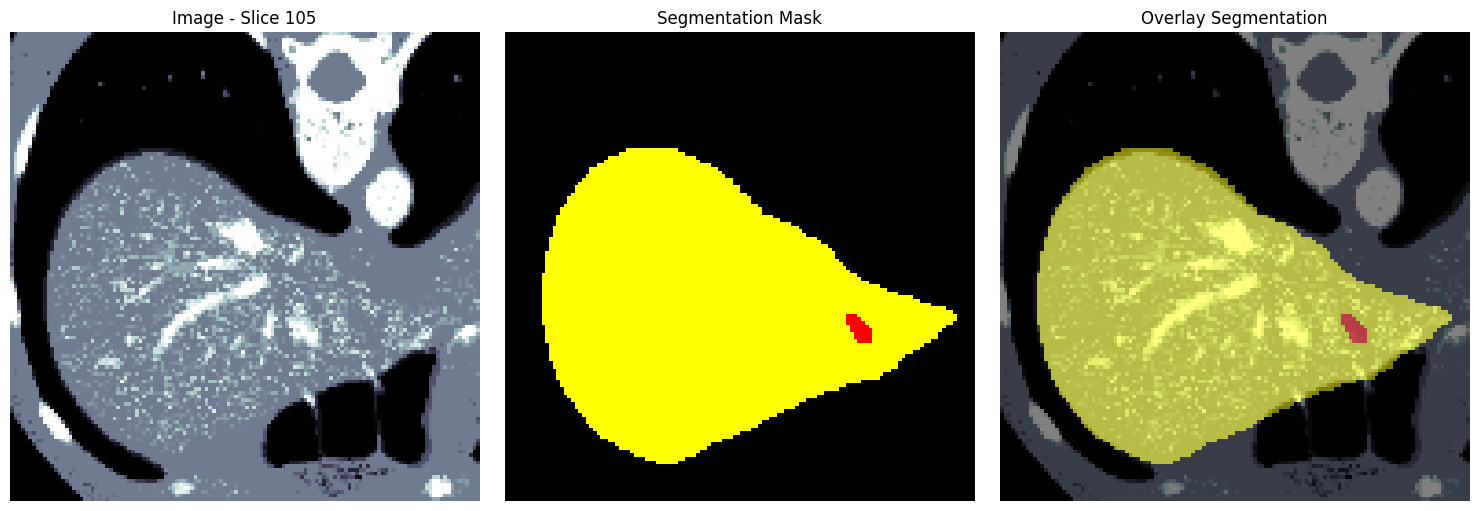

In [18]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as mcolors

# Define colormap for segmentation classes
cmap = mcolors.ListedColormap(["black", "yellow", "red", "green", "blue", "purple"])
bounds = [0, 1, 2, 3, 4, 5]
norm = mcolors.BoundaryNorm(bounds, cmap.N)

for batch in train_loader:
    image_sample = batch['image']  # Shape: [1, 1, 128, 128, 128]
    label_sample = batch['label']  # Shape: [1, 1, 128, 128, 128]

    label_data = label_sample[0, 0].numpy()  # shape: [128, 128, 128]
    image_data = image_sample[0, 0].numpy()

    # Tìm tất cả slice index có tumor
    tumor_slices = np.any(label_data == 2, axis=(1, 2))


    slice_idx = np.argmax(tumor_slices)

    img_slice = image_data[slice_idx, :, :]
    label_slice = label_data[slice_idx, :, :]

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    axes[0].imshow(img_slice, cmap=plt.cm.bone)
    axes[0].set_title(f"Image - Slice {slice_idx}")
    axes[0].axis("off")

    axes[1].imshow(label_slice, cmap=cmap, norm=norm)
    axes[1].set_title("Segmentation Mask")
    axes[1].axis("off")

    axes[2].imshow(img_slice, cmap=plt.cm.bone)
    axes[2].imshow(label_slice, cmap=cmap, norm=norm, alpha=0.5)
    axes[2].set_title("Overlay Segmentation")
    axes[2].axis("off")

    plt.tight_layout()
    plt.show()
    break


## Model

In [9]:
model = ModelFactory.get_model("unet3d",in_channels=1, n_classes=3, n_channels=16).to(device)
print('Number of network parameters:', sum(param.numel() for param in model.parameters()))

Number of network parameters: 2512515


## Training

In [10]:
criterion = DiceLossWSoftmax().to(device)

dice_acc = DiceMetric(include_background=False, reduction='mean_batch', get_not_nans=True)

optimizer = torch.optim.AdamW(model.parameters(), lr=float(config["learning_rate"]), weight_decay=float(config["weight_decay"]))
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=int(config["max_epochs"]), eta_min = float(config["eta_min"]))

In [ ]:
LOGGER.info("[TRAINER] Start TRAIN process...")

(
    val_acc_max,
    best_epoch,
    dices_liver,
    dices_tumor,
    dices_avg,
    loss_epochs,
    trains_epoch,
    ious_liver,
    ious_tumor,
    ious_avg,
    precisions_liver,
    precisions_tumor,
    precisions_avg,
    recalls_liver,
    recalls_tumor,
    recalls_avg,
    time_tmp,
) = trainer(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    loss_func=criterion,
    acc_func=dice_acc,
    scheduler=scheduler,
    batch_size=config["batch_size"],
    max_epochs=20,
    start_epoch=11,
    val_every=config["val_every"],
    path_save_model=config["path_save_model_state"],
    logger=LOGGER,
    save_model=True,
)

[TRAINER] Start TRAIN process...
INFO:kltn.utils.logger:[TRAINER] Start TRAIN process...

==============================Training epoch 11==============================
INFO:kltn.utils.logger:
==============================Training epoch 11==============================


Epoch 11/20 1/105 loss: 0.3984 time 1.91s
Epoch 11/20 2/105 loss: 0.3865 time 0.98s
Epoch 11/20 3/105 loss: 0.3846 time 4.88s
Epoch 11/20 4/105 loss: 0.3862 time 2.65s
Epoch 11/20 5/105 loss: 0.3819 time 4.70s
Epoch 11/20 6/105 loss: 0.3747 time 7.55s
Epoch 11/20 7/105 loss: 0.3755 time 6.41s
Epoch 11/20 8/105 loss: 0.3719 time 1.15s
Epoch 11/20 9/105 loss: 0.3771 time 4.04s
Epoch 11/20 10/105 loss: 0.3749 time 1.11s
Epoch 11/20 11/105 loss: 0.3743 time 2.11s
Epoch 11/20 12/105 loss: 0.3708 time 7.51s
Epoch 11/20 13/105 loss: 0.3730 time 3.21s
Epoch 11/20 14/105 loss: 0.3720 time 6.54s
Epoch 11/20 15/105 loss: 0.3706 time 4.85s
Epoch 11/20 16/105 loss: 0.3709 time 5.11s
Epoch 11/20 17/105 loss: 0.3732 time 5.35s
Epoch 11/20 18/105 loss: 0.3724 time 6.04s
Epoch 11/20 19/105 loss: 0.3730 time 7.03s
Epoch 11/20 20/105 loss: 0.3732 time 5.57s
Epoch 11/20 21/105 loss: 0.3727 time 6.71s
Epoch 11/20 22/105 loss: 0.3721 time 3.16s
Epoch 11/20 23/105 loss: 0.3713 time 6.56s
Epoch 11/20 24/105 l

Final training epochs: 11/20 ---[loss: 0.3737] ---[time 420.56s]
INFO:kltn.utils.logger:Final training epochs: 11/20 ---[loss: 0.3737] ---[time 420.56s]

********************Epoch 11 Validation********************
INFO:kltn.utils.logger:
********************Epoch 11 Validation********************


Epoch 11/20 105/105 loss: 0.3737 time 1.20s


Val 11/20 1/26, Dice_Liver: 0.902259, Dice_Tumor: 0.000000, Dice_Avg: 0.451130, time 7.75s
INFO:kltn.utils.logger:Val 11/20 1/26, Dice_Liver: 0.902259, Dice_Tumor: 0.000000, Dice_Avg: 0.451130, time 7.75s
Val 11/20 2/26, Dice_Liver: 0.886506, Dice_Tumor: 0.000000, Dice_Avg: 0.443253, time 1.90s
INFO:kltn.utils.logger:Val 11/20 2/26, Dice_Liver: 0.886506, Dice_Tumor: 0.000000, Dice_Avg: 0.443253, time 1.90s
Val 11/20 3/26, Dice_Liver: 0.872921, Dice_Tumor: 0.000000, Dice_Avg: 0.436460, time 4.95s
INFO:kltn.utils.logger:Val 11/20 3/26, Dice_Liver: 0.872921, Dice_Tumor: 0.000000, Dice_Avg: 0.436460, time 4.95s
Val 11/20 4/26, Dice_Liver: 0.873679, Dice_Tumor: 0.000000, Dice_Avg: 0.436839, time 1.10s
INFO:kltn.utils.logger:Val 11/20 4/26, Dice_Liver: 0.873679, Dice_Tumor: 0.000000, Dice_Avg: 0.436839, time 1.10s
Val 11/20 5/26, Dice_Liver: 0.848981, Dice_Tumor: 0.000000, Dice_Avg: 0.424490, time 0.57s
INFO:kltn.utils.logger:Val 11/20 5/26, Dice_Liver: 0.848981, Dice_Tumor: 0.000000, Dice_A

New best (0.000000 --> 0.422352). At epoch 11
Epoch 12/20 1/105 loss: 0.3728 time 4.40s
Epoch 12/20 2/105 loss: 0.3591 time 0.91s
Epoch 12/20 3/105 loss: 0.3644 time 5.84s
Epoch 12/20 4/105 loss: 0.3535 time 9.55s
Epoch 12/20 5/105 loss: 0.3617 time 3.82s
Epoch 12/20 6/105 loss: 0.3665 time 2.48s
Epoch 12/20 7/105 loss: 0.3693 time 3.40s
Epoch 12/20 8/105 loss: 0.3616 time 1.98s
Epoch 12/20 9/105 loss: 0.3640 time 6.65s
Epoch 12/20 10/105 loss: 0.3600 time 6.09s
Epoch 12/20 11/105 loss: 0.3570 time 3.05s
Epoch 12/20 12/105 loss: 0.3542 time 4.46s
Epoch 12/20 13/105 loss: 0.3579 time 1.47s
Epoch 12/20 14/105 loss: 0.3595 time 1.01s
Epoch 12/20 15/105 loss: 0.3580 time 5.60s
Epoch 12/20 16/105 loss: 0.3614 time 4.36s
Epoch 12/20 17/105 loss: 0.3609 time 1.86s
Epoch 12/20 18/105 loss: 0.3619 time 5.59s
Epoch 12/20 19/105 loss: 0.3625 time 6.30s
Epoch 12/20 20/105 loss: 0.3641 time 3.42s
Epoch 12/20 21/105 loss: 0.3644 time 4.10s
Epoch 12/20 22/105 loss: 0.3631 time 0.92s
Epoch 12/20 23/10

Final training epochs: 12/20 ---[loss: 0.3733] ---[time 409.69s]
INFO:kltn.utils.logger:Final training epochs: 12/20 ---[loss: 0.3733] ---[time 409.69s]

********************Epoch 12 Validation********************
INFO:kltn.utils.logger:
********************Epoch 12 Validation********************


Epoch 12/20 105/105 loss: 0.3733 time 1.32s


Val 12/20 1/26, Dice_Liver: 0.919527, Dice_Tumor: 0.000000, Dice_Avg: 0.459764, time 7.23s
INFO:kltn.utils.logger:Val 12/20 1/26, Dice_Liver: 0.919527, Dice_Tumor: 0.000000, Dice_Avg: 0.459764, time 7.23s
Val 12/20 2/26, Dice_Liver: 0.885725, Dice_Tumor: 0.000000, Dice_Avg: 0.442863, time 2.24s
INFO:kltn.utils.logger:Val 12/20 2/26, Dice_Liver: 0.885725, Dice_Tumor: 0.000000, Dice_Avg: 0.442863, time 2.24s
Val 12/20 3/26, Dice_Liver: 0.847589, Dice_Tumor: 0.000000, Dice_Avg: 0.423795, time 4.90s
INFO:kltn.utils.logger:Val 12/20 3/26, Dice_Liver: 0.847589, Dice_Tumor: 0.000000, Dice_Avg: 0.423795, time 4.90s
Val 12/20 4/26, Dice_Liver: 0.847994, Dice_Tumor: 0.000000, Dice_Avg: 0.423997, time 1.03s
INFO:kltn.utils.logger:Val 12/20 4/26, Dice_Liver: 0.847994, Dice_Tumor: 0.000000, Dice_Avg: 0.423997, time 1.03s
Val 12/20 5/26, Dice_Liver: 0.754810, Dice_Tumor: 0.000000, Dice_Avg: 0.377405, time 0.57s
INFO:kltn.utils.logger:Val 12/20 5/26, Dice_Liver: 0.754810, Dice_Tumor: 0.000000, Dice_A

Epoch 13/20 1/105 loss: 0.3608 time 2.00s
Epoch 13/20 2/105 loss: 0.3879 time 2.02s
Epoch 13/20 3/105 loss: 0.4011 time 1.57s
Epoch 13/20 4/105 loss: 0.3879 time 5.24s
Epoch 13/20 5/105 loss: 0.3921 time 2.57s
Epoch 13/20 6/105 loss: 0.3885 time 7.29s
Epoch 13/20 7/105 loss: 0.3867 time 6.28s
Epoch 13/20 8/105 loss: 0.3869 time 4.95s
Epoch 13/20 9/105 loss: 0.3889 time 2.85s
Epoch 13/20 10/105 loss: 0.3886 time 1.12s
Epoch 13/20 11/105 loss: 0.3845 time 5.79s
Epoch 13/20 12/105 loss: 0.3839 time 5.68s
Epoch 13/20 13/105 loss: 0.3825 time 1.85s
Epoch 13/20 14/105 loss: 0.3820 time 4.58s
Epoch 13/20 15/105 loss: 0.3799 time 6.53s
Epoch 13/20 16/105 loss: 0.3767 time 4.84s
Epoch 13/20 17/105 loss: 0.3771 time 6.08s
Epoch 13/20 18/105 loss: 0.3767 time 1.06s
Epoch 13/20 19/105 loss: 0.3762 time 1.36s
Epoch 13/20 20/105 loss: 0.3752 time 2.29s
Epoch 13/20 21/105 loss: 0.3729 time 5.40s
Epoch 13/20 22/105 loss: 0.3730 time 6.90s
Epoch 13/20 23/105 loss: 0.3713 time 3.33s
Epoch 13/20 24/105 l

Final training epochs: 13/20 ---[loss: 0.3718] ---[time 424.99s]
INFO:kltn.utils.logger:Final training epochs: 13/20 ---[loss: 0.3718] ---[time 424.99s]

********************Epoch 13 Validation********************
INFO:kltn.utils.logger:
********************Epoch 13 Validation********************


Epoch 13/20 105/105 loss: 0.3718 time 5.58s


Val 13/20 1/26, Dice_Liver: 0.918087, Dice_Tumor: 0.000000, Dice_Avg: 0.459044, time 7.55s
INFO:kltn.utils.logger:Val 13/20 1/26, Dice_Liver: 0.918087, Dice_Tumor: 0.000000, Dice_Avg: 0.459044, time 7.55s
Val 13/20 2/26, Dice_Liver: 0.886171, Dice_Tumor: 0.000000, Dice_Avg: 0.443086, time 2.49s
INFO:kltn.utils.logger:Val 13/20 2/26, Dice_Liver: 0.886171, Dice_Tumor: 0.000000, Dice_Avg: 0.443086, time 2.49s
Val 13/20 3/26, Dice_Liver: 0.840658, Dice_Tumor: 0.000000, Dice_Avg: 0.420329, time 5.91s
INFO:kltn.utils.logger:Val 13/20 3/26, Dice_Liver: 0.840658, Dice_Tumor: 0.000000, Dice_Avg: 0.420329, time 5.91s
Val 13/20 4/26, Dice_Liver: 0.845150, Dice_Tumor: 0.000000, Dice_Avg: 0.422575, time 1.31s
INFO:kltn.utils.logger:Val 13/20 4/26, Dice_Liver: 0.845150, Dice_Tumor: 0.000000, Dice_Avg: 0.422575, time 1.31s
Val 13/20 5/26, Dice_Liver: 0.791048, Dice_Tumor: 0.000000, Dice_Avg: 0.395524, time 0.63s
INFO:kltn.utils.logger:Val 13/20 5/26, Dice_Liver: 0.791048, Dice_Tumor: 0.000000, Dice_A

Epoch 14/20 1/105 loss: 0.4235 time 8.40s
Epoch 14/20 2/105 loss: 0.3878 time 0.94s
Epoch 14/20 3/105 loss: 0.3802 time 5.16s
Epoch 14/20 4/105 loss: 0.3732 time 6.14s
Epoch 14/20 5/105 loss: 0.3745 time 3.24s
Epoch 14/20 6/105 loss: 0.3730 time 4.97s
Epoch 14/20 7/105 loss: 0.3600 time 2.68s
Epoch 14/20 8/105 loss: 0.3639 time 1.01s
Epoch 14/20 9/105 loss: 0.3670 time 8.33s
Epoch 14/20 10/105 loss: 0.3706 time 1.37s
Epoch 14/20 11/105 loss: 0.3704 time 5.14s
Epoch 14/20 12/105 loss: 0.3678 time 1.19s
Epoch 14/20 13/105 loss: 0.3695 time 4.96s
Epoch 14/20 14/105 loss: 0.3653 time 5.62s
Epoch 14/20 15/105 loss: 0.3623 time 1.82s
Epoch 14/20 16/105 loss: 0.3626 time 1.43s
Epoch 14/20 17/105 loss: 0.3631 time 8.15s
Epoch 14/20 18/105 loss: 0.3656 time 3.10s
Epoch 14/20 19/105 loss: 0.3666 time 0.78s
Epoch 14/20 20/105 loss: 0.3655 time 1.11s
Epoch 14/20 21/105 loss: 0.3662 time 1.40s
Epoch 14/20 22/105 loss: 0.3660 time 7.89s
Epoch 14/20 23/105 loss: 0.3644 time 8.01s
Epoch 14/20 24/105 l

Final training epochs: 14/20 ---[loss: 0.3676] ---[time 469.98s]
INFO:kltn.utils.logger:Final training epochs: 14/20 ---[loss: 0.3676] ---[time 469.98s]

********************Epoch 14 Validation********************
INFO:kltn.utils.logger:
********************Epoch 14 Validation********************


Epoch 14/20 105/105 loss: 0.3676 time 7.25s


Val 14/20 1/26, Dice_Liver: 0.903833, Dice_Tumor: 0.000000, Dice_Avg: 0.451917, time 8.01s
INFO:kltn.utils.logger:Val 14/20 1/26, Dice_Liver: 0.903833, Dice_Tumor: 0.000000, Dice_Avg: 0.451917, time 8.01s
Val 14/20 2/26, Dice_Liver: 0.870140, Dice_Tumor: 0.000000, Dice_Avg: 0.435070, time 2.18s
INFO:kltn.utils.logger:Val 14/20 2/26, Dice_Liver: 0.870140, Dice_Tumor: 0.000000, Dice_Avg: 0.435070, time 2.18s
Val 14/20 3/26, Dice_Liver: 0.752135, Dice_Tumor: 0.000000, Dice_Avg: 0.376067, time 5.93s
INFO:kltn.utils.logger:Val 14/20 3/26, Dice_Liver: 0.752135, Dice_Tumor: 0.000000, Dice_Avg: 0.376067, time 5.93s
Val 14/20 4/26, Dice_Liver: 0.775829, Dice_Tumor: 0.000000, Dice_Avg: 0.387914, time 1.33s
INFO:kltn.utils.logger:Val 14/20 4/26, Dice_Liver: 0.775829, Dice_Tumor: 0.000000, Dice_Avg: 0.387914, time 1.33s
Val 14/20 5/26, Dice_Liver: 0.705155, Dice_Tumor: 0.000000, Dice_Avg: 0.352577, time 0.64s
INFO:kltn.utils.logger:Val 14/20 5/26, Dice_Liver: 0.705155, Dice_Tumor: 0.000000, Dice_A

Epoch 15/20 1/105 loss: 0.3901 time 2.07s
Epoch 15/20 2/105 loss: 0.3584 time 6.40s
Epoch 15/20 3/105 loss: 0.3694 time 3.62s
Epoch 15/20 4/105 loss: 0.3486 time 4.56s
Epoch 15/20 5/105 loss: 0.3469 time 5.43s
Epoch 15/20 6/105 loss: 0.3420 time 6.40s
Epoch 15/20 7/105 loss: 0.3448 time 1.48s
Epoch 15/20 8/105 loss: 0.3523 time 1.42s
Epoch 15/20 9/105 loss: 0.3481 time 8.33s
Epoch 15/20 10/105 loss: 0.3482 time 1.49s
Epoch 15/20 11/105 loss: 0.3497 time 4.66s
Epoch 15/20 12/105 loss: 0.3535 time 0.99s
Epoch 15/20 13/105 loss: 0.3543 time 3.73s
Epoch 15/20 14/105 loss: 0.3557 time 1.94s
Epoch 15/20 15/105 loss: 0.3583 time 6.64s
Epoch 15/20 16/105 loss: 0.3569 time 1.02s
Epoch 15/20 17/105 loss: 0.3553 time 6.54s
Epoch 15/20 18/105 loss: 0.3572 time 1.94s
Epoch 15/20 19/105 loss: 0.3573 time 3.82s
Epoch 15/20 20/105 loss: 0.3578 time 5.93s
Epoch 15/20 21/105 loss: 0.3612 time 4.55s
Epoch 15/20 22/105 loss: 0.3625 time 7.37s
Epoch 15/20 23/105 loss: 0.3644 time 1.39s
Epoch 15/20 24/105 l

Final training epochs: 15/20 ---[loss: 0.3682] ---[time 427.67s]
INFO:kltn.utils.logger:Final training epochs: 15/20 ---[loss: 0.3682] ---[time 427.67s]

********************Epoch 15 Validation********************
INFO:kltn.utils.logger:
********************Epoch 15 Validation********************


Epoch 15/20 105/105 loss: 0.3682 time 7.33s


Val 15/20 1/26, Dice_Liver: 0.921767, Dice_Tumor: 0.156726, Dice_Avg: 0.539247, time 7.10s
INFO:kltn.utils.logger:Val 15/20 1/26, Dice_Liver: 0.921767, Dice_Tumor: 0.156726, Dice_Avg: 0.539247, time 7.10s
Val 15/20 2/26, Dice_Liver: 0.897044, Dice_Tumor: 0.115041, Dice_Avg: 0.506043, time 1.92s
INFO:kltn.utils.logger:Val 15/20 2/26, Dice_Liver: 0.897044, Dice_Tumor: 0.115041, Dice_Avg: 0.506043, time 1.92s
Val 15/20 3/26, Dice_Liver: 0.885163, Dice_Tumor: 0.115041, Dice_Avg: 0.500102, time 5.99s
INFO:kltn.utils.logger:Val 15/20 3/26, Dice_Liver: 0.885163, Dice_Tumor: 0.115041, Dice_Avg: 0.500102, time 5.99s
Val 15/20 4/26, Dice_Liver: 0.880326, Dice_Tumor: 0.115041, Dice_Avg: 0.497683, time 1.14s
INFO:kltn.utils.logger:Val 15/20 4/26, Dice_Liver: 0.880326, Dice_Tumor: 0.115041, Dice_Avg: 0.497683, time 1.14s
Val 15/20 5/26, Dice_Liver: 0.800957, Dice_Tumor: 0.076694, Dice_Avg: 0.438826, time 0.55s
INFO:kltn.utils.logger:Val 15/20 5/26, Dice_Liver: 0.800957, Dice_Tumor: 0.076694, Dice_A

New best (0.422352 --> 0.489605). At epoch 15
Epoch 16/20 1/105 loss: 0.4117 time 4.82s
Epoch 16/20 2/105 loss: 0.3865 time 2.75s
Epoch 16/20 3/105 loss: 0.3808 time 5.20s
Epoch 16/20 4/105 loss: 0.3832 time 1.43s
Epoch 16/20 5/105 loss: 0.3782 time 4.90s
Epoch 16/20 6/105 loss: 0.3788 time 1.24s
Epoch 16/20 7/105 loss: 0.3739 time 2.49s
Epoch 16/20 8/105 loss: 0.3675 time 5.28s
Epoch 16/20 9/105 loss: 0.3714 time 8.84s
Epoch 16/20 10/105 loss: 0.3721 time 4.31s
Epoch 16/20 11/105 loss: 0.3740 time 0.71s
Epoch 16/20 12/105 loss: 0.3715 time 1.44s
Epoch 16/20 13/105 loss: 0.3760 time 6.86s
Epoch 16/20 14/105 loss: 0.3763 time 7.24s
Epoch 16/20 15/105 loss: 0.3716 time 5.29s
Epoch 16/20 16/105 loss: 0.3665 time 5.84s
Epoch 16/20 17/105 loss: 0.3670 time 1.64s
Epoch 16/20 18/105 loss: 0.3672 time 2.96s
Epoch 16/20 19/105 loss: 0.3684 time 5.57s
Epoch 16/20 20/105 loss: 0.3691 time 1.09s
Epoch 16/20 21/105 loss: 0.3659 time 8.26s
Epoch 16/20 22/105 loss: 0.3656 time 5.51s
Epoch 16/20 23/10

Final training epochs: 16/20 ---[loss: 0.3654] ---[time 425.57s]
INFO:kltn.utils.logger:Final training epochs: 16/20 ---[loss: 0.3654] ---[time 425.57s]

********************Epoch 16 Validation********************
INFO:kltn.utils.logger:
********************Epoch 16 Validation********************


Epoch 16/20 105/105 loss: 0.3654 time 2.78s


Val 16/20 1/26, Dice_Liver: 0.894788, Dice_Tumor: 0.299809, Dice_Avg: 0.597299, time 7.33s
INFO:kltn.utils.logger:Val 16/20 1/26, Dice_Liver: 0.894788, Dice_Tumor: 0.299809, Dice_Avg: 0.597299, time 7.33s
Val 16/20 2/26, Dice_Liver: 0.831311, Dice_Tumor: 0.197094, Dice_Avg: 0.514203, time 1.91s
INFO:kltn.utils.logger:Val 16/20 2/26, Dice_Liver: 0.831311, Dice_Tumor: 0.197094, Dice_Avg: 0.514203, time 1.91s
Val 16/20 3/26, Dice_Liver: 0.636728, Dice_Tumor: 0.197094, Dice_Avg: 0.416911, time 5.93s
INFO:kltn.utils.logger:Val 16/20 3/26, Dice_Liver: 0.636728, Dice_Tumor: 0.197094, Dice_Avg: 0.416911, time 5.93s
Val 16/20 4/26, Dice_Liver: 0.672583, Dice_Tumor: 0.197094, Dice_Avg: 0.434839, time 1.12s
INFO:kltn.utils.logger:Val 16/20 4/26, Dice_Liver: 0.672583, Dice_Tumor: 0.197094, Dice_Avg: 0.434839, time 1.12s
Val 16/20 5/26, Dice_Liver: 0.599623, Dice_Tumor: 0.131396, Dice_Avg: 0.365509, time 0.52s
INFO:kltn.utils.logger:Val 16/20 5/26, Dice_Liver: 0.599623, Dice_Tumor: 0.131396, Dice_A

Epoch 17/20 1/105 loss: 0.3939 time 6.61s
Epoch 17/20 2/105 loss: 0.3778 time 6.62s
Epoch 17/20 3/105 loss: 0.3683 time 4.95s
Epoch 17/20 4/105 loss: 0.3758 time 2.78s
Epoch 17/20 5/105 loss: 0.3789 time 3.90s
Epoch 17/20 6/105 loss: 0.3845 time 3.00s
Epoch 17/20 7/105 loss: 0.3836 time 5.36s
Epoch 17/20 8/105 loss: 0.3824 time 2.61s
Epoch 17/20 9/105 loss: 0.3795 time 2.30s
Epoch 17/20 10/105 loss: 0.3789 time 5.72s
Epoch 17/20 11/105 loss: 0.3791 time 5.56s
Epoch 17/20 12/105 loss: 0.3800 time 4.61s
Epoch 17/20 13/105 loss: 0.3817 time 1.43s
Epoch 17/20 14/105 loss: 0.3816 time 4.38s
Epoch 17/20 15/105 loss: 0.3812 time 1.43s
Epoch 17/20 16/105 loss: 0.3820 time 6.37s
Epoch 17/20 17/105 loss: 0.3817 time 2.22s
Epoch 17/20 18/105 loss: 0.3811 time 2.00s
Epoch 17/20 19/105 loss: 0.3810 time 5.92s
Epoch 17/20 20/105 loss: 0.3804 time 1.09s
Epoch 17/20 21/105 loss: 0.3797 time 4.46s
Epoch 17/20 22/105 loss: 0.3774 time 9.28s
Epoch 17/20 23/105 loss: 0.3759 time 1.73s
Epoch 17/20 24/105 l

Final training epochs: 17/20 ---[loss: 0.3671] ---[time 421.05s]
INFO:kltn.utils.logger:Final training epochs: 17/20 ---[loss: 0.3671] ---[time 421.05s]

********************Epoch 17 Validation********************
INFO:kltn.utils.logger:
********************Epoch 17 Validation********************


Epoch 17/20 105/105 loss: 0.3671 time 7.15s


Val 17/20 1/26, Dice_Liver: 0.909969, Dice_Tumor: 0.157734, Dice_Avg: 0.533851, time 7.68s
INFO:kltn.utils.logger:Val 17/20 1/26, Dice_Liver: 0.909969, Dice_Tumor: 0.157734, Dice_Avg: 0.533851, time 7.68s
Val 17/20 2/26, Dice_Liver: 0.857484, Dice_Tumor: 0.317450, Dice_Avg: 0.587467, time 1.91s
INFO:kltn.utils.logger:Val 17/20 2/26, Dice_Liver: 0.857484, Dice_Tumor: 0.317450, Dice_Avg: 0.587467, time 1.91s
Val 17/20 3/26, Dice_Liver: 0.782526, Dice_Tumor: 0.317450, Dice_Avg: 0.549988, time 5.08s
INFO:kltn.utils.logger:Val 17/20 3/26, Dice_Liver: 0.782526, Dice_Tumor: 0.317450, Dice_Avg: 0.549988, time 5.08s
Val 17/20 4/26, Dice_Liver: 0.800832, Dice_Tumor: 0.317450, Dice_Avg: 0.559141, time 1.01s
INFO:kltn.utils.logger:Val 17/20 4/26, Dice_Liver: 0.800832, Dice_Tumor: 0.317450, Dice_Avg: 0.559141, time 1.01s
Val 17/20 5/26, Dice_Liver: 0.740009, Dice_Tumor: 0.211634, Dice_Avg: 0.475821, time 0.54s
INFO:kltn.utils.logger:Val 17/20 5/26, Dice_Liver: 0.740009, Dice_Tumor: 0.211634, Dice_A

New best (0.489605 --> 0.513664). At epoch 17
Epoch 18/20 1/105 loss: 0.3802 time 2.10s
Epoch 18/20 2/105 loss: 0.3474 time 4.60s
Epoch 18/20 3/105 loss: 0.3354 time 3.36s
Epoch 18/20 4/105 loss: 0.3301 time 1.45s
Epoch 18/20 5/105 loss: 0.3430 time 1.45s
Epoch 18/20 6/105 loss: 0.3485 time 2.06s
Epoch 18/20 7/105 loss: 0.3396 time 4.69s
Epoch 18/20 8/105 loss: 0.3402 time 2.87s
Epoch 18/20 9/105 loss: 0.3415 time 6.56s
Epoch 18/20 10/105 loss: 0.3446 time 4.53s
Epoch 18/20 11/105 loss: 0.3462 time 5.83s
Epoch 18/20 12/105 loss: 0.3470 time 7.04s
Epoch 18/20 13/105 loss: 0.3482 time 6.27s
Epoch 18/20 14/105 loss: 0.3473 time 1.31s
Epoch 18/20 15/105 loss: 0.3464 time 6.30s
Epoch 18/20 16/105 loss: 0.3461 time 0.79s
Epoch 18/20 17/105 loss: 0.3464 time 1.72s
Epoch 18/20 18/105 loss: 0.3498 time 5.75s
Epoch 18/20 19/105 loss: 0.3470 time 5.70s
Epoch 18/20 20/105 loss: 0.3464 time 6.56s
Epoch 18/20 21/105 loss: 0.3487 time 4.44s
Epoch 18/20 22/105 loss: 0.3506 time 5.04s
Epoch 18/20 23/10

Final training epochs: 18/20 ---[loss: 0.3623] ---[time 428.54s]
INFO:kltn.utils.logger:Final training epochs: 18/20 ---[loss: 0.3623] ---[time 428.54s]

********************Epoch 18 Validation********************
INFO:kltn.utils.logger:
********************Epoch 18 Validation********************


Epoch 18/20 105/105 loss: 0.3623 time 4.54s


Val 18/20 1/26, Dice_Liver: 0.899154, Dice_Tumor: 0.030204, Dice_Avg: 0.464679, time 7.37s
INFO:kltn.utils.logger:Val 18/20 1/26, Dice_Liver: 0.899154, Dice_Tumor: 0.030204, Dice_Avg: 0.464679, time 7.37s
Val 18/20 2/26, Dice_Liver: 0.895846, Dice_Tumor: 0.073730, Dice_Avg: 0.484788, time 1.88s
INFO:kltn.utils.logger:Val 18/20 2/26, Dice_Liver: 0.895846, Dice_Tumor: 0.073730, Dice_Avg: 0.484788, time 1.88s
Val 18/20 3/26, Dice_Liver: 0.867131, Dice_Tumor: 0.073730, Dice_Avg: 0.470431, time 5.80s
INFO:kltn.utils.logger:Val 18/20 3/26, Dice_Liver: 0.867131, Dice_Tumor: 0.073730, Dice_Avg: 0.470431, time 5.80s
Val 18/20 4/26, Dice_Liver: 0.870031, Dice_Tumor: 0.073730, Dice_Avg: 0.471881, time 0.98s
INFO:kltn.utils.logger:Val 18/20 4/26, Dice_Liver: 0.870031, Dice_Tumor: 0.073730, Dice_Avg: 0.471881, time 0.98s
Val 18/20 5/26, Dice_Liver: 0.837252, Dice_Tumor: 0.049154, Dice_Avg: 0.443203, time 0.53s
INFO:kltn.utils.logger:Val 18/20 5/26, Dice_Liver: 0.837252, Dice_Tumor: 0.049154, Dice_A

Epoch 19/20 1/105 loss: 0.3614 time 2.07s
Epoch 19/20 2/105 loss: 0.3828 time 1.35s
Epoch 19/20 3/105 loss: 0.3688 time 9.46s
Epoch 19/20 4/105 loss: 0.3704 time 6.01s
Epoch 19/20 5/105 loss: 0.3702 time 6.20s
Epoch 19/20 6/105 loss: 0.3644 time 3.38s
Epoch 19/20 7/105 loss: 0.3693 time 4.66s
Epoch 19/20 8/105 loss: 0.3703 time 1.29s
Epoch 19/20 9/105 loss: 0.3706 time 4.36s
Epoch 19/20 10/105 loss: 0.3698 time 2.94s
Epoch 19/20 11/105 loss: 0.3718 time 6.35s
Epoch 19/20 12/105 loss: 0.3725 time 4.90s
Epoch 19/20 13/105 loss: 0.3730 time 6.87s
Epoch 19/20 14/105 loss: 0.3759 time 6.03s
Epoch 19/20 15/105 loss: 0.3762 time 5.22s
Epoch 19/20 16/105 loss: 0.3739 time 5.79s
Epoch 19/20 17/105 loss: 0.3750 time 5.15s
Epoch 19/20 18/105 loss: 0.3760 time 5.09s
Epoch 19/20 19/105 loss: 0.3779 time 6.05s
Epoch 19/20 20/105 loss: 0.3742 time 5.73s
Epoch 19/20 21/105 loss: 0.3742 time 3.46s
Epoch 19/20 22/105 loss: 0.3761 time 2.01s
Epoch 19/20 23/105 loss: 0.3752 time 5.10s
Epoch 19/20 24/105 l

Final training epochs: 19/20 ---[loss: 0.3645] ---[time 418.43s]
INFO:kltn.utils.logger:Final training epochs: 19/20 ---[loss: 0.3645] ---[time 418.43s]

********************Epoch 19 Validation********************
INFO:kltn.utils.logger:
********************Epoch 19 Validation********************


Epoch 19/20 105/105 loss: 0.3645 time 5.44s


Val 19/20 1/26, Dice_Liver: 0.901751, Dice_Tumor: 0.259740, Dice_Avg: 0.580745, time 6.96s
INFO:kltn.utils.logger:Val 19/20 1/26, Dice_Liver: 0.901751, Dice_Tumor: 0.259740, Dice_Avg: 0.580745, time 6.96s
Val 19/20 2/26, Dice_Liver: 0.869129, Dice_Tumor: 0.356903, Dice_Avg: 0.613016, time 1.87s
INFO:kltn.utils.logger:Val 19/20 2/26, Dice_Liver: 0.869129, Dice_Tumor: 0.356903, Dice_Avg: 0.613016, time 1.87s
Val 19/20 3/26, Dice_Liver: 0.770362, Dice_Tumor: 0.356903, Dice_Avg: 0.563633, time 5.61s
INFO:kltn.utils.logger:Val 19/20 3/26, Dice_Liver: 0.770362, Dice_Tumor: 0.356903, Dice_Avg: 0.563633, time 5.61s
Val 19/20 4/26, Dice_Liver: 0.792548, Dice_Tumor: 0.356903, Dice_Avg: 0.574726, time 1.07s
INFO:kltn.utils.logger:Val 19/20 4/26, Dice_Liver: 0.792548, Dice_Tumor: 0.356903, Dice_Avg: 0.574726, time 1.07s
Val 19/20 5/26, Dice_Liver: 0.727740, Dice_Tumor: 0.237935, Dice_Avg: 0.482838, time 0.55s
INFO:kltn.utils.logger:Val 19/20 5/26, Dice_Liver: 0.727740, Dice_Tumor: 0.237935, Dice_A

New best (0.513664 --> 0.514035). At epoch 19
Epoch 20/20 1/105 loss: 0.4010 time 5.11s
Epoch 20/20 2/105 loss: 0.3417 time 9.38s
Epoch 20/20 3/105 loss: 0.3572 time 2.82s
Epoch 20/20 4/105 loss: 0.3535 time 5.26s
Epoch 20/20 5/105 loss: 0.3577 time 5.59s
Epoch 20/20 6/105 loss: 0.3553 time 0.85s
Epoch 20/20 7/105 loss: 0.3559 time 4.69s
Epoch 20/20 8/105 loss: 0.3555 time 1.41s
Epoch 20/20 9/105 loss: 0.3581 time 7.08s
Epoch 20/20 10/105 loss: 0.3539 time 1.01s
Epoch 20/20 11/105 loss: 0.3562 time 5.15s
Epoch 20/20 12/105 loss: 0.3538 time 5.16s
Epoch 20/20 13/105 loss: 0.3531 time 2.58s
Epoch 20/20 14/105 loss: 0.3553 time 6.40s
Epoch 20/20 15/105 loss: 0.3580 time 4.94s
Epoch 20/20 16/105 loss: 0.3587 time 2.11s
Epoch 20/20 17/105 loss: 0.3602 time 6.40s
Epoch 20/20 18/105 loss: 0.3621 time 6.74s
Epoch 20/20 19/105 loss: 0.3604 time 1.24s
Epoch 20/20 20/105 loss: 0.3595 time 5.59s
Epoch 20/20 21/105 loss: 0.3572 time 7.04s
Epoch 20/20 22/105 loss: 0.3585 time 4.95s
Epoch 20/20 23/10

Final training epochs: 20/20 ---[loss: 0.3611] ---[time 428.23s]
INFO:kltn.utils.logger:Final training epochs: 20/20 ---[loss: 0.3611] ---[time 428.23s]

********************Epoch 20 Validation********************
INFO:kltn.utils.logger:
********************Epoch 20 Validation********************


Epoch 20/20 105/105 loss: 0.3611 time 1.33s


Val 20/20 1/26, Dice_Liver: 0.889175, Dice_Tumor: 0.113320, Dice_Avg: 0.501248, time 7.04s
INFO:kltn.utils.logger:Val 20/20 1/26, Dice_Liver: 0.889175, Dice_Tumor: 0.113320, Dice_Avg: 0.501248, time 7.04s
Val 20/20 2/26, Dice_Liver: 0.873744, Dice_Tumor: 0.076678, Dice_Avg: 0.475211, time 2.28s
INFO:kltn.utils.logger:Val 20/20 2/26, Dice_Liver: 0.873744, Dice_Tumor: 0.076678, Dice_Avg: 0.475211, time 2.28s
Val 20/20 3/26, Dice_Liver: 0.853820, Dice_Tumor: 0.076678, Dice_Avg: 0.465249, time 5.13s
INFO:kltn.utils.logger:Val 20/20 3/26, Dice_Liver: 0.853820, Dice_Tumor: 0.076678, Dice_Avg: 0.465249, time 5.13s
Val 20/20 4/26, Dice_Liver: 0.853918, Dice_Tumor: 0.076678, Dice_Avg: 0.465298, time 1.03s
INFO:kltn.utils.logger:Val 20/20 4/26, Dice_Liver: 0.853918, Dice_Tumor: 0.076678, Dice_Avg: 0.465298, time 1.03s
Val 20/20 5/26, Dice_Liver: 0.806594, Dice_Tumor: 0.051118, Dice_Avg: 0.428856, time 0.53s
INFO:kltn.utils.logger:Val 20/20 5/26, Dice_Liver: 0.806594, Dice_Tumor: 0.051118, Dice_A

In [ ]:
import json
path_save_result = f"/content/drive/MyDrive/KLTN/code/result_model_{model.__class__.__name__}.json"

results = {
    "dice_liver": [float(x) for x in np.array(dices_liver, dtype=np.float32)],
    "dice_tumor": [float(x) for x in np.array(dices_tumor, dtype=np.float32)],
    "dice_avg": [float(x) for x in np.array(dices_avg, dtype = np.float32)],
    "loss": [float(x) for x in np.array(loss_epochs, dtype= np.float32)],
    "iou_liver": [float(x) for x in np.array(ious_liver, dtype=np.float32)],
    "iou_tumor": [float(x) for x in np.array(ious_tumor, dtype=np.float32)],
    "iou_avg": [float(x) for x in np.array(ious_avg, dtype=np.float32)],
    "precision_liver": [float(x) for x in np.array(precisions_liver, dtype=np.float32)],
    "precision_tumor": [float(x) for x in np.array(precisions_tumor, dtype=np.float32)],
    "precision_avg": [float(x) for x in np.array(precisions_avg, dtype=np.float32)],
    "recall_liver": [float(x) for x in np.array(recalls_liver, dtype=np.float32)],
    "recall_tumor": [float(x) for x in np.array(recalls_tumor, dtype=np.float32)],
    "recall_avg": [float(x) for x in np.array(recalls_avg, dtype=np.float32)],
    "best_epoch": best_epoch,
    "time_train": time_tmp
}
with open(path_save_result, "w") as f:
    json.dump(results, f, indent=4)

## Visualize Results

In [ ]:
import glob
print(glob.glob(f"{config['path_save_model_state']}/best_metric_model*"))

['/content/drive/MyDrive/KLTN/code/weight/best_metric_model_UNet3D.pth']


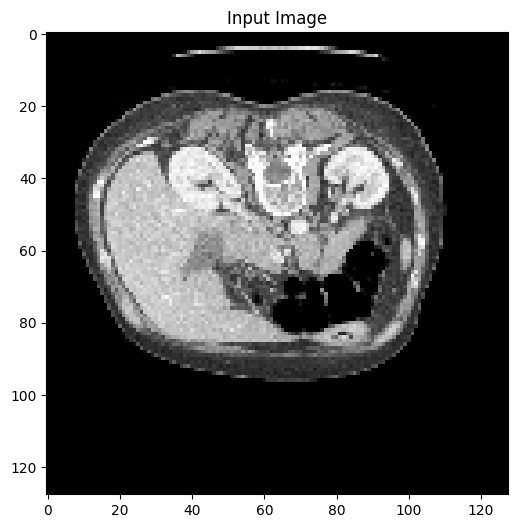

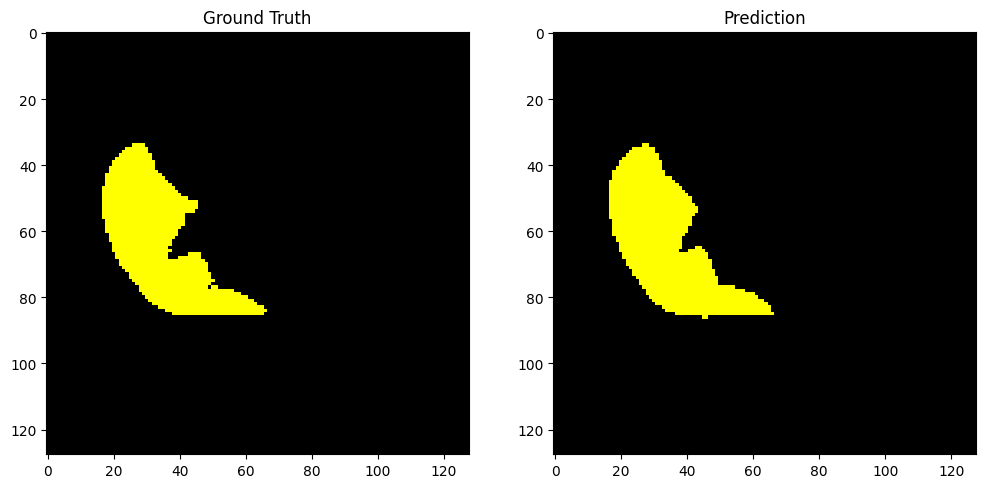

In [ ]:
num_images = 1
weight_path = "/content/drive/MyDrive/KLTN/code/weight/best_metric_model_UNet3D.pth"
visualize_results(model, val_loader, weight_path, num_images, device)